# Are stock splits predictable before or after a split?

The goal of this case study is to examine any trends in stock prices when a company splits their stocks. We'll be looking at the following questions:
<br>
"Do all companies share a similar trend 2 weeks before and after a stock split?"
<br>
"Is the trend stronger depending on if it's similar sectors"
<br>
"Is the trend stronger depending on the split ratio?"
<br>
<br>
"Is there an ideal time to buy in when a stock splits?"
<br>
"In the long term, does timing the market really make a significant difference?"

# PULLING THE DATASET AND CLEANSING THE DATA

Pulling data from the yahoo finance library and creating csv

In [ ]:
!pip install yfinance

In [4]:
#Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

### CREATE CSV OF TOP100 COMPANIES BY MARKET CAP

In [38]:
# Step 1: Retrieve the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url, header=0)
sp500_df = table[0]
tickers = sp500_df['Symbol'].to_list()


# Step 2: Fetch market capitalization data for each company
market_caps = {}
for ticker in tickers:
    try:
        company = yf.Ticker(ticker)
        market_cap = company.info.get('marketCap')
        if market_cap is not None:
            market_caps[ticker] = market_cap
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Step 3: Convert the dictionary to a DataFrame and sort by market cap
market_cap_df = pd.DataFrame(list(market_caps.items()), columns=['Ticker', 'Market Cap'])
sorted_market_cap_df = market_cap_df.sort_values(by='Market Cap', ascending=False)

# Step 4: Filter for the top 100 companies by market cap
top_100_companies = sorted_market_cap_df.head(100)

# Reset index for top_100_companies
top_100_companies.reset_index(drop=True, inplace=True)

# Save the top 100 companies by market cap as a csv
top_100_companies.to_csv('top_100_sp500_companies.csv', index=False)

### CREATE CSV OF COMPANIES HAVE SPLIT STOCK

In [4]:
# Step 1: Read the list of top 100 S&P 500 companies from CSV
top_100_companies_df = pd.read_csv('top_100_sp500_companies.csv')
tickers = top_100_companies_df['Ticker'].tolist()

end_date = datetime.today()

# List to hold split data
split_data_list = []

# Fetching stock split data for each company in the top 100 S&P 500 companies
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        splits = stock.splits
        # Ensure the index is timezone-naive for comparison
        splits.index = splits.index.tz_localize(None)
        # Filter splits
        splits = splits[splits.index <= pd.Timestamp(end_date)]
        if not splits.empty:
            for date, ratio in splits.items():
                split_data_list.append([ticker, date, ratio])
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Create a DataFrame from the collected data
split_data_df = pd.DataFrame(split_data_list, columns=['Ticker', 'Date', 'Split Ratio'])

# Save the DataFrame as a csv
split_data_df.to_csv('stock_splits_top100_sp500_v2.csv', index=False)

In [5]:
#Read in CSV
split_data_df = pd.read_csv('stock_splits_top100_sp500_v2.csv')

# list to hold Companies that have stock split
SS_companies = split_data_df['Ticker'].unique().tolist()
 
print("unique values :", SS_companies)

unique values : ['MSFT', 'AAPL', 'NVDA', 'GOOG', 'GOOGL', 'AMZN', 'LLY', 'JPM', 'TSLA', 'V', 'WMT', 'XOM', 'UNH', 'MA', 'PG', 'COST', 'JNJ', 'HD', 'ORCL', 'MRK', 'BAC', 'CVX', 'NFLX', 'KO', 'AMD', 'PEP', 'QCOM', 'CRM', 'TMO', 'LIN', 'WFC', 'TMUS', 'ADBE', 'DHR', 'DIS', 'CSCO', 'MCD', 'GE', 'AMAT', 'ABT', 'TXN', 'VZ', 'AXP', 'CAT', 'NEE', 'AMGN', 'PFE', 'INTU', 'MS', 'CMCSA', 'IBM', 'NKE', 'RTX', 'ISRG', 'UNP', 'MU', 'COP', 'SCHW', 'SPGI', 'ETN', 'HON', 'INTC', 'T', 'SYK', 'BKNG', 'LOW', 'ELV', 'PGR', 'LRCX', 'C', 'VRTX', 'TJX', 'ADI', 'LMT', 'BSX', 'CB', 'BA', 'MDT', 'DE', 'MMC', 'KLAC', 'ADP', 'CI', 'PANW', 'ANET']


### CREATE CSV OF THESE COMPANIES AND THEIR PRICE HISTORY FROM THE PAST DECADE

In [17]:
##Get the historical data from all companies that have stock split
split_data_df = pd.read_csv('stock_splits_top100_sp500_v2.csv')

# List to Unique Companies that have stock split
SS_companies = split_data_df['Ticker'].unique().tolist()


# List to hold historical data
historical_data_list = []

# Fetching historical data for each company that has had a stock split
for ticker in SS_companies:
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history("max")
        hist.reset_index(inplace=True)
        hist['Ticker'] = ticker
        sector = stock.info.get('sector', 'Unknown')  # Use .get() to handle missing sector information
        sector_df.at[index, 'Sector'] = sector
        historical_data_list.append(hist)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

In [18]:
# Concatenate all historical data into a single DataFrame
historical_data_df = pd.concat(historical_data_list, ignore_index=True)

# Convert the 'Date' column to datetime format
historical_data_df['Date'] = pd.to_datetime(historical_data_df['Date'])

# Remove the timezone information
historical_data_df['Date'] = historical_data_df['Date'].dt.tz_localize(None)

# Optionally, you can format the 'Date' column to show only year, month, and day
historical_data_df['Date'] = historical_data_df['Date'].dt.strftime('%Y-%m-%d')

# Save the modified dataframe back to a CSV file
historical_data_df.to_csv('modified_historical_data_top100_sp500_v2.csv', index=False)

print("CSV file saved successfully.")

CSV file saved successfully.


# ANALYZE STOCK PRICES FROM HISTORICAL STOCK SPLIT TREND FROM NVIDIA

In [5]:
historical_data_df = pd.read_csv('modified_historical_data_top100_sp500_v2.csv')

historical_data_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,1986-03-13,0.054693,0.062736,0.054693,0.060055,1031788800,0.0,0.0,MSFT
1,1986-03-14,0.060055,0.063272,0.060055,0.062199,308160000,0.0,0.0,MSFT
2,1986-03-17,0.062199,0.063808,0.062199,0.063272,133171200,0.0,0.0,MSFT
3,1986-03-18,0.063272,0.063808,0.061127,0.061663,67766400,0.0,0.0,MSFT
4,1986-03-19,0.061663,0.062199,0.060055,0.060591,47894400,0.0,0.0,MSFT


In [20]:
print(historical_data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903442 entries, 0 to 903441
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          903442 non-null  object 
 1   Open          903442 non-null  float64
 2   High          903442 non-null  float64
 3   Low           903442 non-null  float64
 4   Close         903442 non-null  float64
 5   Volume        903442 non-null  int64  
 6   Dividends     903442 non-null  float64
 7   Stock Splits  903442 non-null  float64
 8   Ticker        903442 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 62.0+ MB
None


## 1.) WHAT TRENDS CAN BE SEEN WHEN NVIDIA ANNOUNCED THEIR 1:10 STOCK SPLIT ON MAY 22ND, 2024?

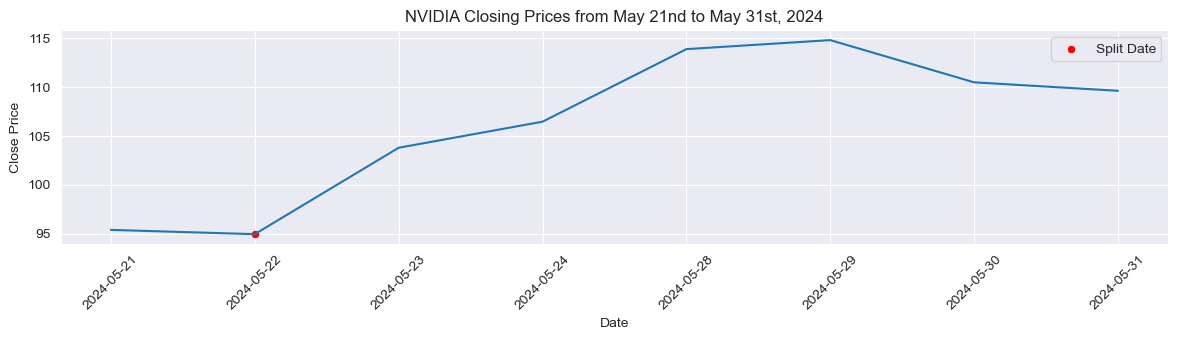

In [35]:
#FILTER FOR NVIDIA DATA FROM HISTORICAL DATA
nvda_hist = historical_data_df[historical_data_df['Ticker'] == "NVDA"]

# Convert the 'Date' column to datetime format
historical_data_df['Date'] = pd.to_datetime(historical_data_df['Date'])

# Filter the NVIDIA data for the specified date range
nvda_recent_hist = nvda_hist[(nvda_hist['Date'] >= '2024-05-21') & (nvda_hist['Date'] <= '2024-05-31')]

# Plot the data
plt.figure(figsize=(12, 3.5))
sns.lineplot(x='Date', y='Close', data=nvda_recent_hist)

# Mark a red dot at the point for May 22nd
sns.scatterplot(x='Date', y='Close', data=nvda_recent_hist[nvda_recent_hist['Date'] == '2024-05-22'], color='red', label='Split Date')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Set the title and labels
plt.title('NVIDIA Closing Prices from May 21nd to May 31st, 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Show the plot
plt.tight_layout()
plt.show()

### Calculate how much NVIDIA has increased since stock announcing

In [36]:
# Extract the Close prices for May 22nd and May 31st
close_price_may_22 = nvda_recent_hist[nvda_recent_hist['Date'] == '2024-05-22']['Close'].values[0]
close_price_may_31 = nvda_recent_hist[nvda_recent_hist['Date'] == '2024-05-31']['Close'].values[0]

# Calculate the increase in stock price from May 22nd to May 31st
increase_may_22_to_31 = close_price_may_31 - close_price_may_22

# Find the peak highest price on May 29th
peak_highest_price_may_29 = nvda_recent_hist[nvda_recent_hist['Date'] == '2024-05-29']['Close'].values[0]

# Calculate the percent increase from May 22nd to May 31st
percent_increase_may_22_to_31 = ((close_price_may_31 - close_price_may_22) / close_price_may_22) * 100

# Calculate the percent increase from May 22nd to the peak highest price on May 29th
percent_increase_may_22_to_peak_may_29 = ((peak_highest_price_may_29 - close_price_may_22) / close_price_may_22) * 100

# Print the results
print("Since May 22nd, NVIDIA stocks have increased {:.2f}% as of May 31st, peaking as high as {:.2f}% on May 29th.".format(percent_increase_may_22_to_31, percent_increase_may_22_to_peak_may_29))

Since May 22nd, NVIDIA stocks have increased 15.46% as of May 31st, peaking as high as 20.93% on May 29th.


## 2.) WERE THERE ANY SIMILAR TRENDS WHEN NVIDIA ANNOUNCED THEIR 1:4 STOCK SPLIT ON JULY 20TH, 2021? 

#### Many companies announce their splits at different times, so to standardize our analysis, we'll be observing the same time window for every split: 3 weeks before and 3 weeks after the split.

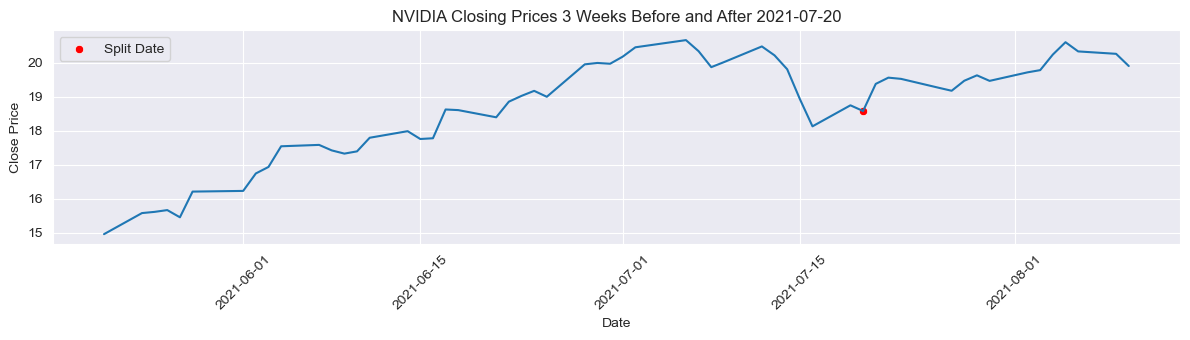

In [37]:
#FILTER FOR NVIDIA DATA FROM HISTORICAL DATA
nvda_hist = historical_data_df[historical_data_df['Ticker'] == "NVDA"]

# Convert the 'Date' column to datetime format
historical_data_df['Date'] = pd.to_datetime(historical_data_df['Date'])

#Find dates of announcement and 3 weeks after split date (date format)
split_date = datetime(2021, 7, 20)
split_announcement = "2021-05-21"
three_weeks_after = split_date + timedelta(weeks=3)

# Filter the NVIDIA data for the specified date range
nvda_split_hist = nvda_hist[(nvda_hist['Date'] >= split_announcement) & (nvda_hist['Date'] <= three_weeks_after)]

# Plot the data
plt.figure(figsize=(12,3.5))
sns.lineplot(x='Date', y='Close', data=nvda_split_hist)

# Mark a red dot at the point for the split date
sns.scatterplot(x= nvda_hist[nvda_hist['Date'] == split_date]['Date'], 
            y= nvda_hist[nvda_hist['Date'] == split_date]['Close'], 
            color='red', label='Split Date')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Set the title and labels
plt.title('NVIDIA Closing Prices 3 Weeks Before and After 2021-07-20')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Show the plot with legend
plt.tight_layout()
plt.legend()
plt.show()

In [38]:
# Filter the NVIDIA data for the period before the split date
nvda_before_split = nvda_split_hist[nvda_split_hist['Date'] <= '2021-07-20']

# Find the minimum and maximum closing prices before the split
close_at_split = nvda_split_hist[nvda_split_hist['Date'] == '2021-07-20']['Close'].values[0]
min_close_before_split = nvda_before_split['Close'].min()
max_close_before_split = nvda_before_split['Close'].max()


print(f"Minimum closing price before the split: {min_close_before_split:.2f}")
print(f"Maximum closing price before the split: {max_close_before_split:.2f} //Percent Increase: {round(((max_close_before_split - min_close_before_split) / max_close_before_split) * 100, 2)}%")
print(f"Closing price at split: {close_at_split:.2f} //Percent Increase: {round(((close_at_split - min_close_before_split) / close_at_split) * 100, 2)}%")

# Filter the NVIDIA data for the period after  the split date
nvda_after_split = nvda_split_hist[nvda_split_hist['Date'] >= '2021-07-20']

# Find the minimum and maximum closing prices before the split
min_close_after_split = nvda_after_split['Close'].min()
max_close_after_split = nvda_after_split['Close'].max()

print()
print(f"Minimum closing price after the split: {min_close_after_split:.2f}")
print(f"Maximum closing price after the split: {max_close_after_split:.2f} //Percent Increase: {round(((max_close_after_split - close_at_split) / max_close_after_split) * 100, 2)}%")


Minimum closing price before the split: 14.96
Maximum closing price before the split: 20.66 //Percent Increase: 27.59%
Closing price at split: 18.58 //Percent Increase: 19.47%

Minimum closing price after the split: 18.58
Maximum closing price after the split: 20.60 //Percent Increase: 9.81%


Stocks increased after announcment on May 21st, increasing by 28% peak before we see a sell off a few days before the stock split. 
<br>
After split, prices did not go down but continued up, indiciating that more stockholders were buying shares then selling shares, continuing to push the price up by 9.81% 3 weeks after the split.
<br>
<b>Based on this trend, it seems most beneifical to buy in immediately after a stock announcement is made.<b>

# ANALYZE STOCK SPLITS TRENDS WITH STATISTICAL TESTS

## We'll be using a independent t-test to analyze the stock patterns before and after the split. The results of this analysis will show if there is consistent trend across different stocks in terms of their returs relative to the split even. Significant tests with a p-value of less than 0.05 will suggests that stock split events may have an impact on the average return of the stocks.

## DO ALL STOCKS SPLITS HAVE A SIMILAR TREND?

In [89]:
##Get the historical data from all companies that have stock split
split_data_df = pd.read_csv('stock_splits_top100_sp500_v2.csv')
split_data_df['Split Ratio'] = round(split_data_df['Split Ratio'],2)
split_data_df['Split Name'] = split_data_df.apply(lambda row: f"{row['Ticker']} {row['Split Ratio']}: {row['Date']}", axis=1)
split_data_df

,Ticker,Date,Split Ratio,Split Name
0,MSFT,1987-09-21,2.00,MSFT 2.0: 1987-09-21
1,MSFT,1990-04-16,2.00,MSFT 2.0: 1990-04-16
2,MSFT,1991-06-27,1.50,MSFT 1.5: 1991-06-27
3,MSFT,1992-06-15,1.50,MSFT 1.5: 1992-06-15
4,MSFT,1994-05-23,2.00,MSFT 2.0: 1994-05-23
...,...,...,...,...
436,ADP,2014-10-01,1.14,ADP 1.14: 2014-10-01
437,CI,1998-05-18,3.00,CI 3.0: 1998-05-18
438,CI,2007-06-05,3.00,CI 3.0: 2007-06-05
439,PANW,2022-09-14,3.00,PANW 3.0: 2022-09-14


### Create a Dataframe of all stock splits that occured. Capturing stock prices 6 weeks before and after the split.

### Create 2 new columns: 'Split Name' (for naming convention) and 'Avg_Return' (to calculate average Returns)

In [9]:
##Get the historical data from all companies that have stock split
split_data_df = pd.read_csv('stock_splits_top100_sp500_v2.csv')
split_data_df['Split Ratio'] = round(split_data_df['Split Ratio'],2)

#Create a new column name that will be the title of each graph
split_data_df['Split Name'] = split_data_df.apply(lambda row: f"{row['Ticker']} {row['Split Ratio']}: {row['Date']}", axis=1)


##Get the historical data for stock prices 6 Weeks prior and after for each split
historical_data_list = []

# Iterate over the split data
for index, row in split_data_df.iterrows():
    #Convert date column to date_time format
    split_date = pd.to_datetime(row['Date'])
    
    #Find 3 weeks before and after split_date
    start_date = split_date - timedelta(weeks=6)
    end_state = split_date + timedelta(weeks=6)
    
    #Filter Historical_data_df by company and time_window of stock split date
    Ticker = row['Ticker']
    Split_Name = row['Split Name']
    split_1 = historical_data_df[(historical_data_df['Ticker'] == Ticker)]
    split_1_window = split_1[(split_1['Date'] >= start_date) & (split_1['Date'] <= end_state)].copy()
    
    #Crate new Column called 'Return' to Calculate Averate Returns
    split_1_window['Avg_Return'] = split_1_window['Close'].pct_change()
    
    # Create new Column called "Split Name" to identify this section of data
    split_1_window.loc[:, 'Split Name'] = Split_Name
    
    # Append the filtered DataFrame to the list
    historical_data_list.append(split_1_window)
    
# Combine all the DataFrames in the list into a single DataFrame (if needed)
all_splits_windowed_data = pd.concat(historical_data_list, ignore_index=True)

# Display the result
all_splits_windowed_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Sector,Avg_Return,Split Name
0,1987-08-10,0.222524,0.223060,0.219843,0.221988,56448000,0.0,0.0,MSFT,Technology,NaN,MSFT 2.0: 1987-09-21
1,1987-08-11,0.223060,0.224132,0.216626,0.217698,68544000,0.0,0.0,MSFT,Technology,-0.019322,MSFT 2.0: 1987-09-21
2,1987-08-12,0.217698,0.218235,0.214481,0.214481,42364800,0.0,0.0,MSFT,Technology,-0.014780,MSFT 2.0: 1987-09-21
3,1987-08-13,0.214481,0.224132,0.214481,0.220915,80640000,0.0,0.0,MSFT,Technology,0.030001,MSFT 2.0: 1987-09-21
4,1987-08-14,0.220915,0.222524,0.219843,0.221988,50832000,0.0,0.0,MSFT,Technology,0.004854,MSFT 2.0: 1987-09-21
...,...,...,...,...,...,...,...,...,...,...,...,...
25972,2021-12-23,140.000000,144.539993,139.960007,141.850006,2319700,0.0,0.0,ANET,Technology,0.016627,ANET 4.0: 2021-11-18
25973,2021-12-27,142.869995,148.570007,142.809998,146.839996,2106600,0.0,0.0,ANET,Technology,0.035178,ANET 4.0: 2021-11-18
25974,2021-12-28,145.949997,147.360001,143.630005,144.889999,1567900,0.0,0.0,ANET,Technology,-0.013280,ANET 4.0: 2021-11-18
25975,2021-12-29,145.539993,146.300003,144.149994,145.710007,1149600,0.0,0.0,ANET,Technology,0.005660,ANET 4.0: 2021-11-18


### Graph all Splits

In [ ]:
# Get unique split names
split_names = all_splits_windowed_data['Split Name'].unique()

# Extract split ratios and sort split names by split ratio
split_names_sorted = sorted(split_names, key=lambda name: float(name.split()[1].split(':')[0]))

# Set up the plotting environment
num_plots = len(split_names_sorted)
cols = 5  # Number of columns of subplots
rows = (num_plots // cols) + (num_plots % cols > 0)  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), sharex=False, sharey=False)
axes = axes.flatten()  # Flatten in case we have a single row

# Plot each split
for i, split_name in enumerate(split_names_sorted):
    ax = axes[i]
    split_df = all_splits_windowed_data[all_splits_windowed_data['Split Name'] == split_name]
    ax.plot(split_df['Date'], split_df['Close'], marker='o')
    ax.set_title(split_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.tick_params(axis='x', rotation=45)
    
    # Extract date from split_name
    split_date_str = split_name.split(':')[-1].strip()  # Assuming the split date is after the last colon
    split_date = pd.to_datetime(split_date_str)  # Convert to datetime if necessary
    
    # Find the closing price on the split date
    split_close = split_df[split_df['Date'] == split_date]['Close'].iloc[0]  # Assuming 'Close' is the column containing the closing price

    # Plot stock split point as a red dot
    ax.plot(split_date, split_close, marker='o', color='red', label='Stock Split')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Get unique split names
split_names = all_splits_windowed_data['Split Name'].unique()

# Extract split ratios and sort split names by split ratio
split_names_sorted = sorted(split_names, key=lambda name: float(name.split()[1].split(':')[0]))

# Set up the plotting environment
num_plots = len(split_names_sorted)
cols = 5  # Number of columns of subplots
rows = (num_plots // cols) + (num_plots % cols > 0)  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), sharex=False, sharey=False)
axes = axes.flatten()  # Flatten in case we have a single row

# Plot each split
for i, split_name in enumerate(split_names_sorted):
    ax = axes[i]
    split_df = all_splits_windowed_data[all_splits_windowed_data['Split Name'] == split_name]
    ax.plot(split_df['Date'], split_df['Avg_Return'], marker='o')
    ax.set_title(split_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Avg_Return')
    ax.tick_params(axis='x', rotation=45)
    
    # Extract date from split_name
    split_date_str = split_name.split(':')[-1].strip()  # Assuming the split date is after the last colon
    split_date = pd.to_datetime(split_date_str)  # Convert to datetime if necessary
    
    # Find the closing price on the split date
    split_day = split_df[split_df['Date'] == split_date]['Avg_Return'].iloc[0]  # Assuming 'Close' is the column containing the closing price

    # Plot stock split point as a red dot
    ax.plot(split_date, split_day, marker='o', color='red', label='Stock Split')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Plot average returns for each day relative to the split date

In [43]:
# Create a 'Relative Day' column based on the stock split date
def get_relative_days(df):
    df['Relative Day'] = (df['Date'] - df['Split Date']).dt.days
    return df

# Extract split date from 'Split Name'
all_splits_windowed_data['Split Date'] = all_splits_windowed_data['Split Name'].apply(lambda x: pd.to_datetime(x.split(':')[-1].strip()))

# Apply get_relative_days to the DataFrame
all_splits_windowed_data = get_relative_days(all_splits_windowed_data)

all_splits_windowed_data.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Avg_Return,Split Name,Split Date,Relative Day
0,1987-08-10,0.222524,0.223060,0.219843,0.221988,56448000,0.0,0.0,MSFT,NaN,MSFT 2.0: 1987-09-21,1987-09-21,-42
1,1987-08-11,0.223060,0.224133,0.216626,0.217698,68544000,0.0,0.0,MSFT,-0.019322,MSFT 2.0: 1987-09-21,1987-09-21,-41
2,1987-08-12,0.217698,0.218235,0.214481,0.214481,42364800,0.0,0.0,MSFT,-0.014781,MSFT 2.0: 1987-09-21,1987-09-21,-40


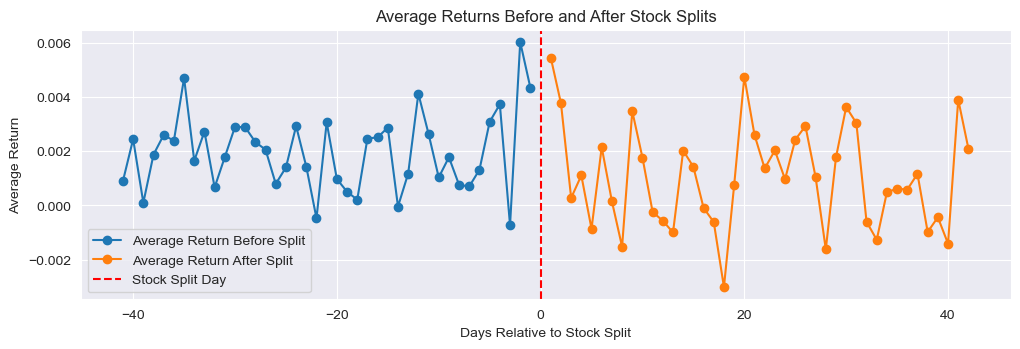

Before Split: T-Statistic: 8.763382344606438, P-Value: 7.526265174243348e-11
After Split: T-Statistic: 3.5435938796323088, P-Value: 0.0010017097169488936


In [48]:
# Step 1: Calculate Average Returns
avg_returns_before = sector_included_df[sector_included_df['Relative Day'] < 0].groupby('Relative Day')['Avg_Return'].mean()
avg_returns_after = sector_included_df[sector_included_df['Relative Day'] > 0].groupby('Relative Day')['Avg_Return'].mean()

# Step 2: Plot the Trends
plt.figure(figsize=(12, 3.5))
plt.plot(avg_returns_before.index, avg_returns_before.values, label='Average Return Before Split', marker='o')
plt.plot(avg_returns_after.index, avg_returns_after.values, label='Average Return After Split', marker='o')
plt.axvline(0, color='red', linestyle='--', label='Stock Split Day')
plt.title('Average Returns Before and After Stock Splits')
plt.xlabel('Days Relative to Stock Split')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()

# Before Split
t_stat_before, p_value_before = ttest_1samp(avg_returns_before.dropna(), 0)
# After Split
t_stat_after, p_value_after = ttest_1samp(avg_returns_after.dropna(), 0)

print(f"Before Split: T-Statistic: {t_stat_before}, P-Value: {p_value_before}")
print(f"After Split: T-Statistic: {t_stat_after}, P-Value: {p_value_after}")


### Run an Independent T-Test

## Interpretting the Results
<b>BEFORE SPLIT<b>
<br>
High T-Statistic (8.7634) indicates a strong deviation of average returns from zero before the stock split.
Extremely Low P-Value (7.53e-11) is much lower than the conventional threshold of 0.05, suggesting a statistically significant change in average returns before the stock split. The results show a strong, statistically significant deviation in average returns from zero. This suggests that average returns before the stock split are not zero, and there is a noticeable pattern or trend in returns leading up to the split.
<br>
<br>
<b>AFTER SPLIT<b>
<br>
Moderate T-Statistic (3.5436) indicates a noticeable deviation of average returns from zero after the stock split.
Low P-Value (0.0010) is also below the threshold of 0.05, suggesting a statistically significant change in average returns after the stock split as well. The results also indicate a statistically significant deviation in average returns from zero, though not as strong as before the split. This suggests that there is a change in average returns following the split, which is also non-zero.
<br>
<br>
<b>Implications<b>
<br>
These results suggest that average returns both before and after stock splits show significant trends or patterns. This could be useful in developing predictive models, although more features and refined models may be needed for better accuracy and reliability.
The strong significance before the split suggests that market participants might anticipate the split and adjust their trading behavior accordingly.


## DO STOCKS SPLITS FROM SIMILAR SECTORS HAVE A SIMILAR TREND?

### Create Dataframe Companies' Sector

In [91]:
# Get Industry Data for Each Stock
split_names = all_splits_windowed_data['Ticker'].unique()

# Create a DataFrame with the Ticker column
sector_df = pd.DataFrame(split_names, columns=['Ticker'])

# Initialize the Industry column with None or an empty string
sector_df['Sector'] = None

# Fetch Industry Data for Each Stock and append to the DataFrame
for index, ticker in enumerate(split_names):
    name = yf.Ticker(ticker)
    sector = name.info.get('sector', 'Unknown')  # Use .get() to handle missing sector information
    sector_df.at[index, 'Sector'] = sector
    
    
sector_df.groupby('Sector').count()

,Ticker
Sector,
Basic Materials,1
Communication Services,8
Consumer Cyclical,8
Consumer Defensive,5
Energy,3
Financial Services,13
Healthcare,16
Industrials,10
Technology,20


### Join Sector_df with all_splits_windowed_data df to get Sector info

In [92]:
print(all_splits_windowed_data.shape)

#Join dataframes to include sector Data
sector_included_df = pd.merge(all_splits_windowed_data, sector_df, how='left', on='Ticker')
sector_included_df

(25972, 13)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Avg_Return,Split Name,Split Date,Relative Day,Sector
0,1987-08-10,0.222524,0.223060,0.219843,0.221988,56448000,0.0,0.0,MSFT,NaN,MSFT 2.0: 1987-09-21,1987-09-21,-42,Technology
1,1987-08-11,0.223060,0.224133,0.216626,0.217698,68544000,0.0,0.0,MSFT,-0.019322,MSFT 2.0: 1987-09-21,1987-09-21,-41,Technology
2,1987-08-12,0.217698,0.218235,0.214481,0.214481,42364800,0.0,0.0,MSFT,-0.014781,MSFT 2.0: 1987-09-21,1987-09-21,-40,Technology
3,1987-08-13,0.214481,0.224132,0.214481,0.220915,80640000,0.0,0.0,MSFT,0.030001,MSFT 2.0: 1987-09-21,1987-09-21,-39,Technology
4,1987-08-14,0.220916,0.222524,0.219843,0.221988,50832000,0.0,0.0,MSFT,0.004855,MSFT 2.0: 1987-09-21,1987-09-21,-38,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25967,2021-12-23,140.000000,144.539993,139.960007,141.850006,2319700,0.0,0.0,ANET,0.016627,ANET 4.0: 2021-11-18,2021-11-18,35,Technology
25968,2021-12-27,142.869995,148.570007,142.809998,146.839996,2106600,0.0,0.0,ANET,0.035178,ANET 4.0: 2021-11-18,2021-11-18,39,Technology
25969,2021-12-28,145.949997,147.360001,143.630005,144.889999,1567900,0.0,0.0,ANET,-0.013280,ANET 4.0: 2021-11-18,2021-11-18,40,Technology
25970,2021-12-29,145.539993,146.300003,144.149994,145.710007,1149600,0.0,0.0,ANET,0.005660,ANET 4.0: 2021-11-18,2021-11-18,41,Technology


### Analyze Subgroups by sector

#### Remove Consumer Defensive, Financial Services, and Utilities as there is only 1 observation

In [59]:
# Step 1: Filter out sectors with only one observation
sector_groups = sector_included_df.groupby('Sector')
sector_groups = [group for group in sector_groups if group[1]['Ticker'].nunique() > 1]

# Step 2: Perform statistical tests for each sector
results = []
for sector, group in sector_groups:
    before_split = group[group['Relative Day'] < 0]['Avg_Return'].dropna()
    after_split = group[group['Relative Day'] > 0]['Avg_Return'].dropna()

    # One-sample t-test to check if mean returns are different from zero
    # Before Split
    t_stat_before, p_value_before = ttest_1samp(before_split, 0)
    # After Split
    t_stat_after, p_value_after = ttest_1samp(after_split, 0)
    
    results.append({
        'Sector': sector,
        'T-Statistic Before': t_stat_before,
        'P-Value Before': p_value_before,
        'T-Statistic After': t_stat_after,
        'P-Value After': p_value_after,
    })
    
# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)

results_df

,Sector,T-Statistic Before,P-Value Before,T-Statistic After,P-Value After
0,Communication Services,3.229365,1.278792e-03,0.977099,0.328735
1,Consumer Cyclical,3.855873,1.211630e-04,1.278056,0.201457
2,Consumer Defensive,1.438134,1.507693e-01,1.152470,0.249445
3,Energy,-0.579411,5.626732e-01,0.466104,0.641410
4,Financial Services,2.227684,2.603776e-02,3.610151,0.000315
5,Healthcare,5.035737,5.144615e-07,2.381651,0.017316
6,Industrials,2.397422,1.661339e-02,1.195407,0.232080
7,Technology,4.692211,2.821301e-06,1.788867,0.073732


### Interpretting the Results
<br>
<b>Significant Mean Returns from all Sectors Before Splits:<br></b>
For several sectors (e.g., Communication Services, Consumer Cyclical, Financial Services, Healthcare, Industrials, Technology), the mean returns before stock splits are significantly different from zero. This suggests a notable pre-split behavior in these sectors.
<br>
<br>
<b>Mixed Results After Splits: <br></b>
The mean returns after stock splits are not significantly different from zero for most sectors, <b>except for Financial Services and Healthcare</b>, indicating a possible post-split effect in these sectors.
<br>
<br>
<b>Financial Services and Healthcare: <br></b>
These sectors show significant mean returns both before and after splits, suggesting a consistent impact around split events.
<br>
<br>

### Graph Sectors with Signicant Trends

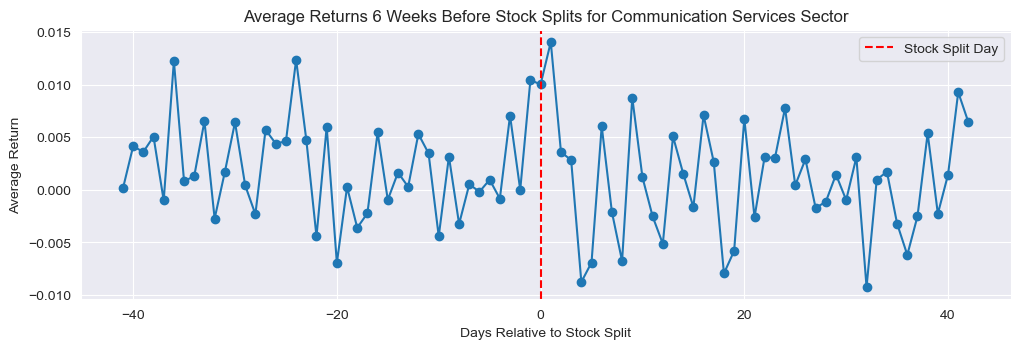

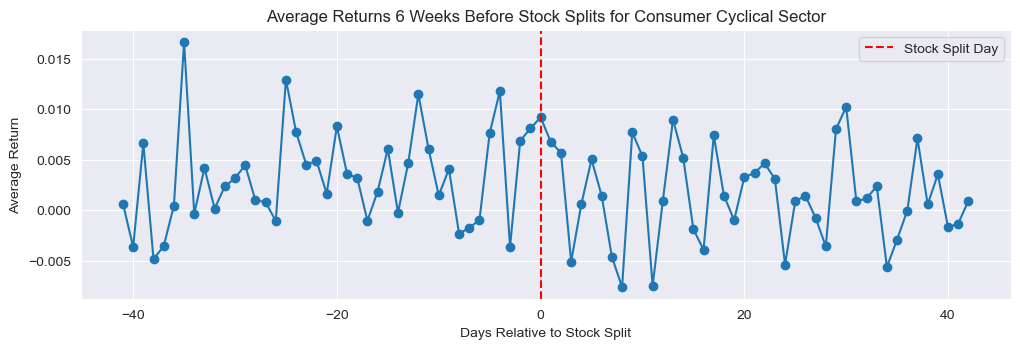

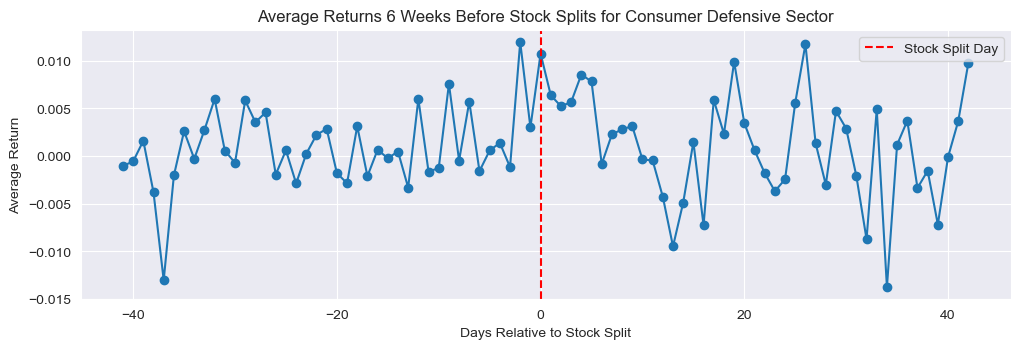

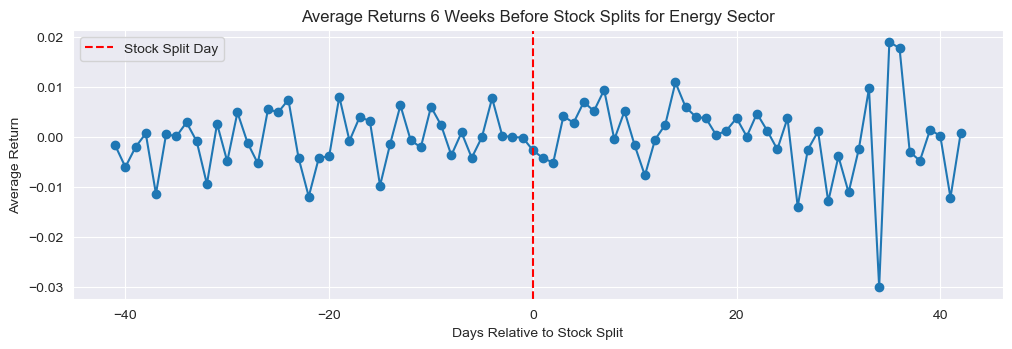

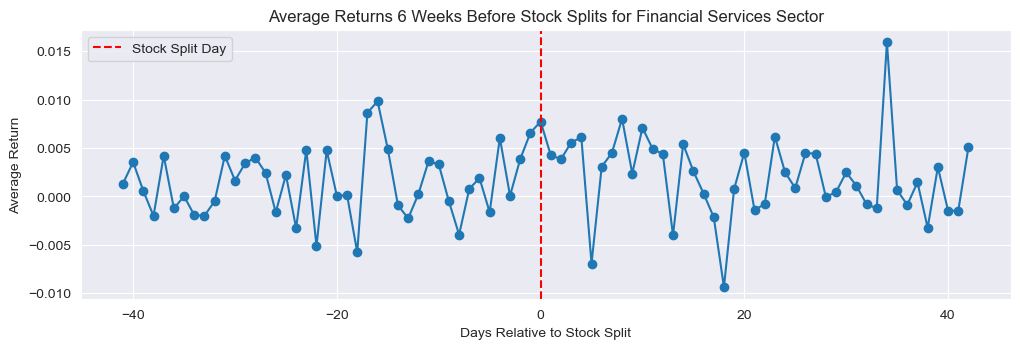

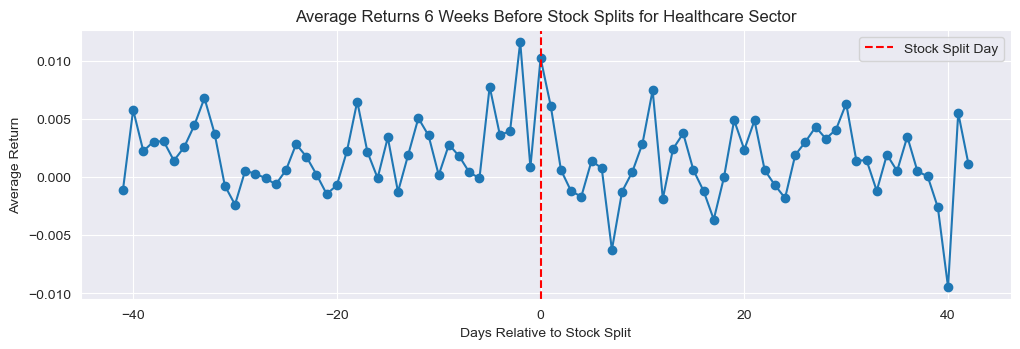

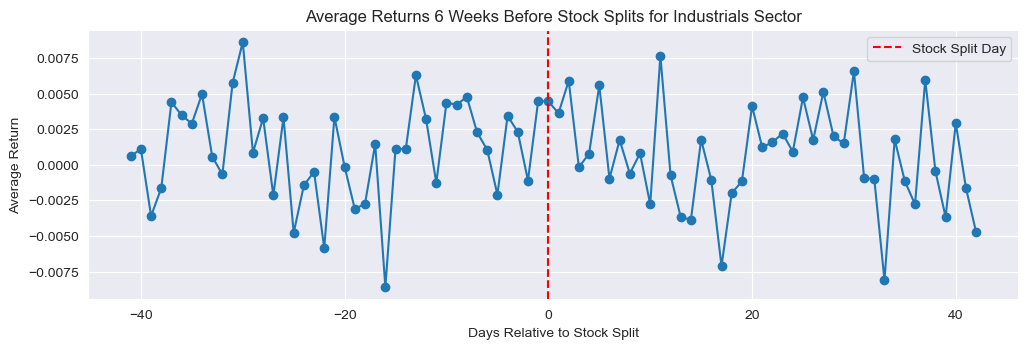

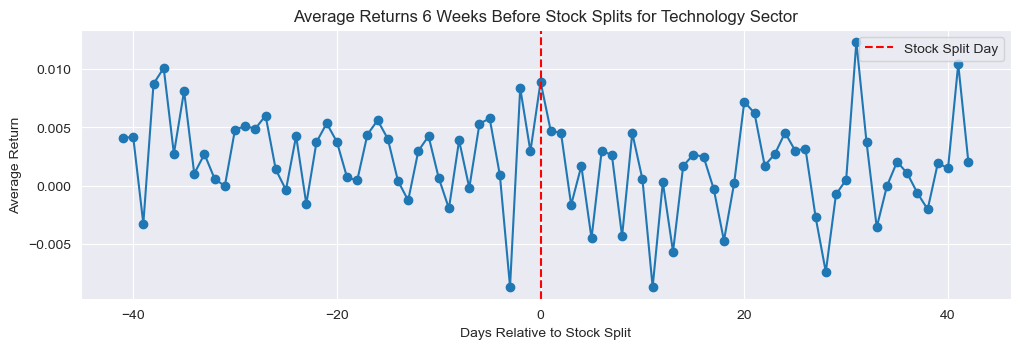

In [81]:
# Prepare to store results
sector_avg_returns = []

# Iterate through each sector group
for sector, group in sector_groups:
    # Filter data for the current sector
    sector_data = group[group['Sector'] == sector]
    sector_data = sector_data.groupby('Relative Day')['Avg_Return'].mean().reset_index()
    
    # Create a new plot for the current sector
    plt.figure(figsize=(12,3.5))
    plt.plot(sector_data['Relative Day'], sector_data['Avg_Return'], marker='o')
    
    # Add labels and title
    plt.axvline(0, color='red', linestyle='--', label='Stock Split Day')
    plt.title(f'Average Returns 6 Weeks Before Stock Splits for {sector} Sector')
    plt.xlabel('Days Relative to Stock Split')
    plt.ylabel('Average Return')
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()

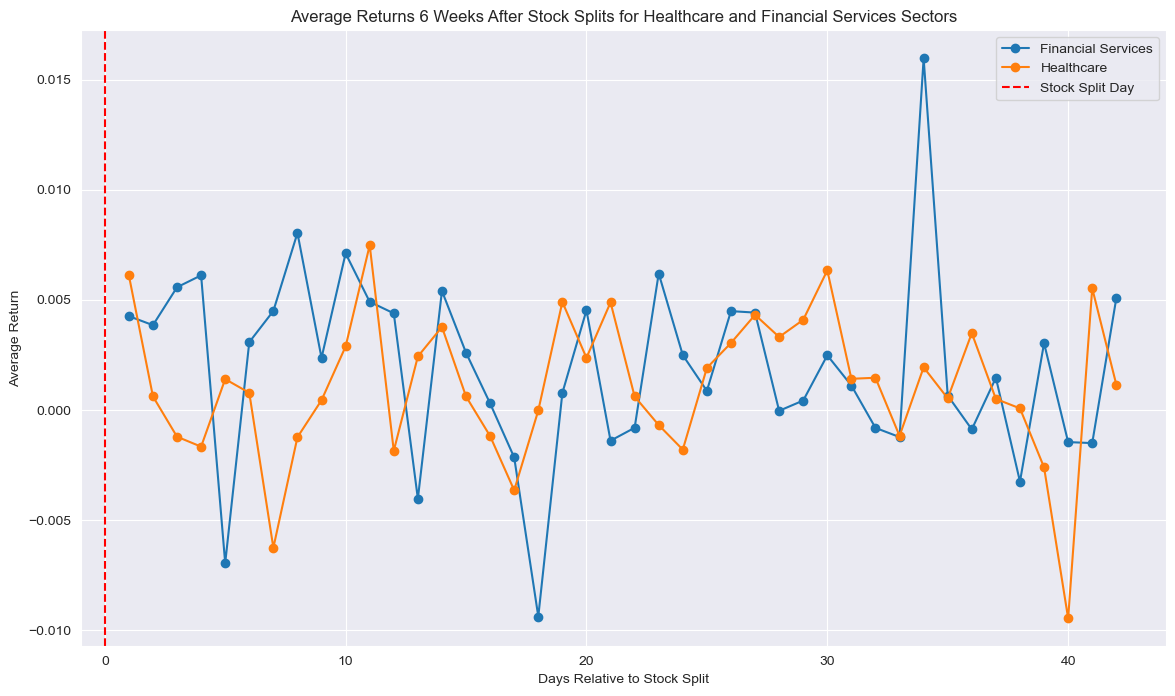

In [60]:
# Prepare to store results
sector_avg_returns = []

# Iterate through each sector group
for sector, group in sector_groups:
    if sector in ["Healthcare", "Financial Services"]:  # Include "Financial Services"
        # Calculate average returns for each relative day after the split
        avg_returns = group[group['Relative Day'] > 0].groupby('Relative Day')['Avg_Return'].mean().reset_index()
        avg_returns['Sector'] = sector
        sector_avg_returns.append(avg_returns)

# Combine all sector average returns into one DataFrame
sector_avg_returns_df = pd.concat(sector_avg_returns, ignore_index=True)

# Plot average returns for the Healthcare and Financial Services sectors after the stock split
plt.figure(figsize=(14, 8))
for sector in sector_avg_returns_df['Sector'].unique():
    sector_data = sector_avg_returns_df[sector_avg_returns_df['Sector'] == sector]
    plt.plot(sector_data['Relative Day'], sector_data['Avg_Return'], marker='o', label=sector)

plt.axvline(0, color='red', linestyle='--', label='Stock Split Day')
plt.title('Average Returns 6 Weeks After Stock Splits for Healthcare and Financial Services Sectors')
plt.xlabel('Days Relative to Stock Split')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.xlim(-1, None) # Adjust x-axis limits
plt.show()

## DO STOCK SPLIT RATIOS HAVE CORRELATIONAL TRENDS?

### Create Split Ratio Subgroups (low split-ratio, medium split-ratio, high split-ratio)

In [82]:
# Define the split ratio bands
low_band = (0.00, 2.00)
medium_band = (2.01, 3.00)
high_band = (3.01, float('inf'))  # Using float('inf') for any split ratio above 5.00

# Sample split ratio data
split_ratios = split_data_df['Split Ratio'].tolist()

# Create a DataFrame with split ratios
df = pd.DataFrame({'Split Ratio': split_ratios})

# Function to categorize split ratios into bands
def categorize_split_ratio(split_ratio):
    if low_band[0] <= split_ratio <= low_band[1]:
        return 'Low'
    elif medium_band[0] <= split_ratio <= medium_band[1]:
        return 'Medium'
    elif split_ratio >= high_band[0]:
        return 'High'

# Apply the categorization function to create a new column 'Split Ratio Band'
df['Split Ratio Band'] = df['Split Ratio'].apply(categorize_split_ratio)

# Print the grouped data
df.groupby('Split Ratio Band').count()

,Split Ratio
Split Ratio Band,
High,19
Low,386
Medium,36


In [83]:
# Extract split ratio from 'Split Name' column
sector_included_df['Split Ratio'] = sector_included_df['Split Name'].str.extract(r'(\d+\.\d+)')

# Function to categorize split ratios into bands
def categorize_split_ratio(split_ratio):
    split_ratio = float(split_ratio)
    if low_band[0] <= split_ratio <= low_band[1]:
        return 'Low'
    elif medium_band[0] <= split_ratio <= medium_band[1]:
        return 'Medium'
    elif split_ratio >= high_band[0]:
        return 'High'

# Apply the categorization function to create a new column 'Split Ratio Band'
sector_included_df['Split Ratio Band'] = sector_included_df['Split Ratio'].apply(categorize_split_ratio)

# Print DataFrame with the new column
sector_included_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Avg_Return,Split Name,Split Date,Relative Day,Sector,Split Ratio,Split Ratio Band
0,1987-08-10,0.222524,0.223060,0.219843,0.221988,56448000,0.0,0.0,MSFT,NaN,MSFT 2.0: 1987-09-21,1987-09-21,-42,Technology,2.0,Low
1,1987-08-11,0.223060,0.224133,0.216626,0.217698,68544000,0.0,0.0,MSFT,-0.019322,MSFT 2.0: 1987-09-21,1987-09-21,-41,Technology,2.0,Low
2,1987-08-12,0.217698,0.218235,0.214481,0.214481,42364800,0.0,0.0,MSFT,-0.014781,MSFT 2.0: 1987-09-21,1987-09-21,-40,Technology,2.0,Low
3,1987-08-13,0.214481,0.224132,0.214481,0.220915,80640000,0.0,0.0,MSFT,0.030001,MSFT 2.0: 1987-09-21,1987-09-21,-39,Technology,2.0,Low
4,1987-08-14,0.220916,0.222524,0.219843,0.221988,50832000,0.0,0.0,MSFT,0.004855,MSFT 2.0: 1987-09-21,1987-09-21,-38,Technology,2.0,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25967,2021-12-23,140.000000,144.539993,139.960007,141.850006,2319700,0.0,0.0,ANET,0.016627,ANET 4.0: 2021-11-18,2021-11-18,35,Technology,4.0,High
25968,2021-12-27,142.869995,148.570007,142.809998,146.839996,2106600,0.0,0.0,ANET,0.035178,ANET 4.0: 2021-11-18,2021-11-18,39,Technology,4.0,High
25969,2021-12-28,145.949997,147.360001,143.630005,144.889999,1567900,0.0,0.0,ANET,-0.013280,ANET 4.0: 2021-11-18,2021-11-18,40,Technology,4.0,High
25970,2021-12-29,145.539993,146.300003,144.149994,145.710007,1149600,0.0,0.0,ANET,0.005660,ANET 4.0: 2021-11-18,2021-11-18,41,Technology,4.0,High


In [84]:
# Group by split ratio bands
split_ratio_groups = sector_included_df.groupby('Split Ratio Band')

# Perform statistical tests for each split ratio band
results = []
for split_ratio_band, group in split_ratio_groups:
    before_split = group[group['Relative Day'] < 0]['Avg_Return'].dropna()
    after_split = group[group['Relative Day'] > 0]['Avg_Return'].dropna()

    # One-sample t-test to check if mean returns are different from zero
    # Before Split
    t_stat_before, p_value_before = ttest_1samp(before_split, 0)
    # After Split
    t_stat_after, p_value_after = ttest_1samp(after_split, 0)
    
    results.append({
        'Split Ratio Band': split_ratio_band,
        'T-Statistic Before': t_stat_before,
        'P-Value Before': p_value_before,
        'T-Statistic After': t_stat_after,
        'P-Value After': p_value_after,
    })
    
# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)

results_df

,Split Ratio Band,T-Statistic Before,P-Value Before,T-Statistic After,P-Value After
0,High,3.329439,9.307457e-04,0.14120,0.887767
1,Low,7.848211,4.619811e-15,4.48852,0.000007
2,Medium,2.180789,2.943079e-02,0.77148,0.440597


### Intrepetting the Results
<b>High Split Ratio Band:</b><br>
<b>Before Split:</b> The t-statistic is 3.329 and the p-value is 0.0009307. This indicates that the mean returns before stock splits are significantly different from zero for stocks with high split ratios, <b>implying that the average returns before stock splits for high split ratio stocks are statistically significant.<br></b>
<b>After Split:</b> The t-statistic is 0.1412 and the p-value is 0.8878. Here, the p-value is greater than 0.05, <b>indicating that the average returns after stock splits for high split ratio stocks are not statistically significant.</b>
<br><br>
<b>Low Split Ratio Band:</b><br>
<b>Before Split:</b> The t-statistic is 7.848 and the p-value is approximately 0. The extremely low p-value <b>indicates that the average returns before stock splits for low split ratio stocks are statistically significant.<br></b>
<b>After Split:</b> The t-statistic is 4.489 and the p-value is 0.000007, <b>indicating that the average returns after stock splits for low split ratio stocks are statistically significant.</b>
<br><br>
<b>Medium Split Ratio Band:</b><br>
<b>Before Split:</b> The t-statistic is 2.181 and the p-value is 0.02943, <b>indicating that the average returns before stock splits for medium split ratio stocks are statistically significant.</b>
<b>After Split:</b> The t-statistic is 0.7715 and the p-value is 0.4406, <b>indicating that the average returns after stock splits for medium split ratio stocks are not statistically significant.</b>
<br>

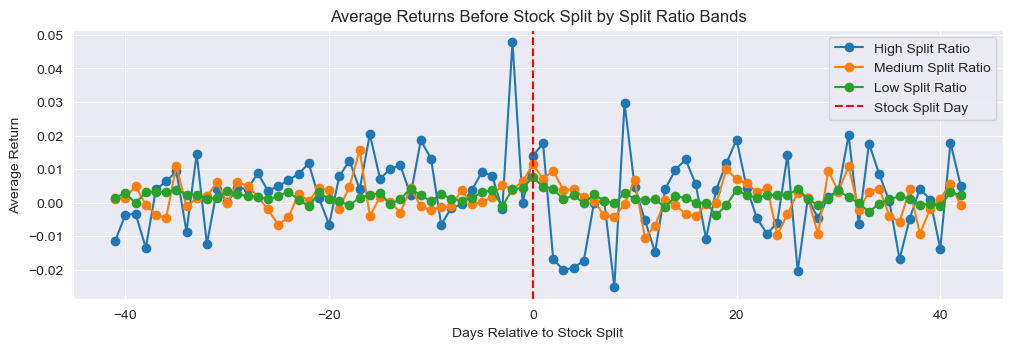

In [85]:
# Define the split ratio bands
split_ratio_bands = ['High', 'Medium', 'Low']

# Plotting average returns for each split ratio band before the stock split
plt.figure(figsize=(12, 3.5))
for band in split_ratio_bands:
    split_grouped = sector_included_df[sector_included_df['Split Ratio Band'] == band].groupby('Relative Day')['Avg_Return'].mean().reset_index()
    plt.plot(split_grouped['Relative Day'], split_grouped['Avg_Return'], marker='o', label=f'{band} Split Ratio')

plt.axvline(0, color='red', linestyle='--', label='Stock Split Day')
plt.title('Average Returns Before Stock Split by Split Ratio Bands')
plt.xlabel('Days Relative to Stock Split')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()
